# SCRIPT 2

Combine processed files into a single drifter dataset, then annotate by deployment?

In [1]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
#import matplotlib.dates as mdates
#import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats
import time
from scipy.io import loadmat # to load bathymetry
import plotly 


%load_ext autoreload
%autoreload 2

# Local import
# > Make sure SIO_wrap dir is on the same path as this script.

from SIO_wrap import dir_tree, fnames
from SIO_wrap.lowess import LatLonLocalWess
from SIO_wrap import jlab_python as jlab
from SIO_wrap import drifter_qc as dqc

from setdir import *



/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


# User edits

In [2]:
# Path for the output data
data_dir = dir_tree.dir_out

#------------
# Names of variables
latname = 'GPS_Latitude_deg'
lonname = 'GPS_Longitude_deg'
uvelname = 'uvel'
vvelname = 'vvel'

#--------------
# Time formats
tstamp_strftime = '%Y%m%d'  # Filename timestamp
timcol_strftime = '%Y-%m-%d %H:%M:%S'  # Convert text to datetime format 

# Reference date for computing time in seconds
# Can use an earlier time reference if data start before 2000
ref_time = datetime.datetime(2000, 1, 1)

#--------------
# List of variable names split between float/int types based on whether the 
# variables are continuous or discrete, respectively.
# <!> If the names of variables change, update the lists by printing a list of 
# all the names from the raw datafile: list(xarrayDataset.keys())

integ_vars = ['Drogue_cnts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF', 
              'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries']

float_vars = [lonname, latname, 'SST_degC',
              'SLP_mB', 'Battery_volts', uvelname, vvelname]


# Step 1. Load proc data


In [2]:
#for i in range(1,1):
i=1
fname = 'TERIFIC_drifters'+str(i)+'.nc'
infile_with_path = cat_proc_path(fname)

ds1 = xr.open_dataset(infile_with_path)

ds1

NameError: name 'cat_proc_path' is not defined

In [20]:
from scipy import interpolate
mfile = 'labsea_66.44W_45.68N_5min'
ds_bathy = xr.open_dataset(cat_proc_path(mfile+'.nc'))

# Use interp to find the bathy nearest a point
lonname = 'lon'
latname = 'lat'

tt = 10
lon1 = ds1[lonname][tt, :].values
lat1 = ds1[latname][tt, :].values

lon = ds_bathy.lon
lat = ds_bathy.lat
da1 = ds_bathy.depth.values
f = interpolate.interp2d(lon, lat, da1, kind='linear')
znew = f(lon1,lat1)
znew1 = znew.diagonal()
#plt.plot(znew)
#plt.show()


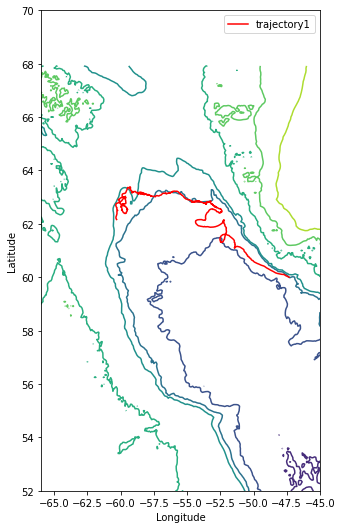

In [23]:

# Set a mercator aspect ratio for maps
# This one is for figure sizes when there's only one axis
def compute_ysize(xsize,lonlim,latlim):
    scale_lon = np.cos(np.mean(latlim)*np.pi/180)
    dlon = lonlim[1]-lonlim[0]
    dlat = latlim[1]-latlim[0]
    ysize = xsize/(dlon*scale_lon)*dlat
    return ysize

# Choose axis limits
latlim = [52, 70]
lonlim = [-66, -45]

axes = plt.subplots(nrows=1, ncols=1)
ax1 = plt.subplot(1,1,1)
ax1.contour(ds_bathy.lon, ds_bathy.lat, ds_bathy.depth)
ax1.set_ylim(latlim)
ax1.set_xlim(lonlim)
fig = plt.gcf()

ax1.plot(lon1,lat1, color='r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel("Latitude")
plt.legend(['trajectory1'])


xsize = 5
ysize = compute_ysize(xsize, lonlim, latlim)

fig.set_size_inches(xsize, ysize)



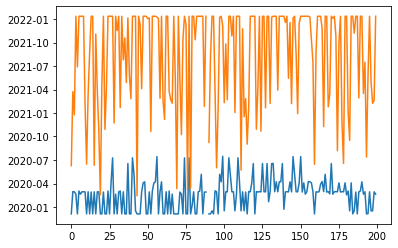

In [63]:
plt.plot(start_time)
plt.plot(end_time)

# Replot as sorted
# https://stackoverflow.com/questions/3382352/equivalent-of-numpy-argsort-in-basic-python

In [14]:
ds_hourly.time.min().values
#ds_hourly.time.max().values

numpy.datetime64('2020-06-15T12:00:00.000000000')

In [ ]:
if 0:

    # ~ ~ print update ~ ~ 
    if len(existing_files) > 0:
        print("Existing raw data files: \n%s\n" % existing_files)
    else:
        sys.exit("No previous raw data files.\n")

    # ~ ~ filenaming convention ~ ~
    # If there are multiple files with raw data (i.e. non-updated datasets), select 
    # the latest one updated.
    # The file names are distinguished by the timestamp appended to the filename 
    # and has <tstamp_strftime> format (see 'user edits' section).
    # The data are cropped such that the last day is fully sampled (spans 0h-23h).
    # The timestamp in the filename is the latest downloaded fully sampled day.

    # Extract the timestamp part of the filename(s) in a list
    tstamp = [date for file in existing_files 
                for date in re.findall("(\d{8})", file)]

    # Convert to datetime and pick the most recent timestamp
    tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
    fname_timestamp = tstamp[tstamp_date.argmax()]

    # Load the raw file with the latest timestamp
    ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
    ds_fpath = os.path.join(data_dir, ds_fname)

    print("Opening file: %s\n" % ds_fpath)
    ds_raw = xr.open_dataset(ds_fpath)
